In [1]:
import math
import numpy as np
import wandb
import random
import torch
import torch_geometric
from torch_geometric.data import Data
import sys
import os
from tqdm import tqdm
import signal
import joblib
import argparse
import json
import os
import subprocess
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import help_functions as hf

scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
    
import gnn_io as gio
import gnn_architectures_district_features as garch
import copy

In [2]:
# Call this function during training without the scalars and with the directory path, and during the testing with the saved scalars and without a directory path to save.
def normalize_dataset(dataset_input, directory_path):
    dataset = copy_subset(dataset_input)
    dataset = normalize_x_values(dataset, directory_path)
    dataset = normalize_positional_features(dataset, directory_path)
    dataset = normalize_mode_stats(dataset, directory_path)
    return dataset
        
# Function to copy a Subset
def copy_subset(subset):
    return Subset(copy.deepcopy(subset.dataset), copy.deepcopy(subset.indices))

def normalize_x_values(dataset, directory_path):
    shape_of_x = dataset[0].x.shape[1]
    list_of_scalers_to_save = []
    x_values = torch.cat([data.x for data in dataset], dim=0)

    for i in range(shape_of_x):
        all_node_features = replace_invalid_values(x_values[:, i].reshape(-1, 1)).numpy()
        
        scaler = StandardScaler()
        print(f"Scaler created for x values at index {i}: {scaler}")
        scaler.fit(all_node_features)
        list_of_scalers_to_save.append(scaler)

        for data in dataset:
            data_x_dim = replace_invalid_values(data.x[:, i].reshape(-1, 1))
            normalized_x_dim = torch.tensor(scaler.transform(data_x_dim.numpy()), dtype=torch.float)
            if i == 0:
                data.normalized_x = normalized_x_dim
            else:
                data.normalized_x = torch.cat((data.normalized_x, normalized_x_dim), dim=1)

    joblib.dump(list_of_scalers_to_save, (directory_path + 'x_scaler.pkl'))
    for data in dataset:
        data.x = data.normalized_x
        del data.normalized_x
    return dataset

def normalize_positional_features(dataset, directory_path):
    # Initialize 6 StandardScalers for 3 sets of 2 dimensions
    scalers = [[StandardScaler() for _ in range(2)] for _ in range(3)]

    # Standardize the data
    for i in range(3):  # Iterate over the second dimension (3 sets)
        for j in range(2):  # Iterate over the third dimension (2D vectors)
            values = np.vstack([data.pos[:, i, j].numpy() for data in dataset]).reshape(-1, 1)
            # Fit the corresponding scaler on the extracted values
            scalers[i][j].fit(values)
            for data in dataset:
                transformed = scalers[i][j].transform(data.pos[:, i, j].numpy().reshape(-1, 1)).flatten()
                # Convert the transformed NumPy array back into a torch tensor
                data.pos[:, i, j] = torch.tensor(transformed, dtype=torch.float32)
    # Save the scalers using joblib
    for i in range(3):
        for j in range(2):
            # Dump the scalers with meaningful names to differentiate them
            scaler_path = directory_path + f'scaler_pos_{i}_{j}.pkl'
            joblib.dump(scalers[i][j], scaler_path)

    print("Postional scalers saved and dataset standardized.")
    return dataset

def normalize_mode_stats(dataset, directory_path):
    # Initialize 12 StandardScalers for 6 sets of 2 dimensions
    scalers = [[StandardScaler() for _ in range(2)] for _ in range(6)]

    # Standardize the data
    for i in range(6):  # Iterate over the first dimension (6 sets)
        for j in range(2):  # Iterate over the second dimension (2D vectors)
            values = np.vstack([data.mode_stats[i, j].numpy().reshape(-1, 1) for data in dataset])
            # Fit the corresponding scaler on the extracted values
            scalers[i][j].fit(values)
            for data in dataset:
                transformed = scalers[i][j].transform(data.mode_stats[i, j].numpy().reshape(-1, 1)).flatten()
                # Convert the transformed NumPy array back into a torch tensor
                data.mode_stats[i, j] = torch.tensor(transformed, dtype=torch.float32)
    
    # Save the scalers using joblib
    for i in range(6):
        for j in range(2):
            # Dump the scalers with meaningful names to differentiate them
            scaler_path = directory_path + f'scaler_mode_stats_{i}_{j}.pkl'
            joblib.dump(scalers[i][j], scaler_path)

    print("Mode stats scalers saved and dataset standardized.")
    return dataset

def replace_invalid_values(tensor):
    tensor[tensor != tensor] = 0  # replace NaNs with 0
    tensor[tensor == float('inf')] = 0  # replace inf with 0
    tensor[tensor == float('-inf')] = 0  # replace -inf with 0
    return tensor

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def prepare_data_with_graph_features(data_dict_list, batch_size, path_to_save_dataloader):
    datalist = [Data(x=d['x'], edge_index=d['edge_index'], pos=d['pos'], y=d['y'], mode_stats=d['mode_stats']) for d in data_dict_list]
    train_set, valid_set, test_set = gio.split_into_subsets(dataset=datalist, train_ratio=0.8, val_ratio=0.15, test_ratio=0.05)
    
    train_set_normalized = normalize_dataset(dataset_input = train_set, directory_path=path_to_save_dataloader + "train_")
    valid_set_normalized = normalize_dataset(dataset_input = valid_set, directory_path=path_to_save_dataloader + "valid_")
    # test_set_normalized = normalize_dataset(dataset_input = test_set, directory_path=path_to_save_dataloader + "test_")
        
    train_loader = DataLoader(dataset=train_set_normalized, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2, pin_memory=True, collate_fn=gio.collate_fn, worker_init_fn=seed_worker)
    val_loader = DataLoader(dataset=valid_set_normalized, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=gio.collate_fn, worker_init_fn=seed_worker)
    # test_loader = DataLoader(dataset=test_set_normalized, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=gio.collate_fn, worker_init_fn=seed_worker)
    # gio.save_dataloader(test_loader, path_to_save_dataloader + 'test_dl.pt')
    # gio.save_dataloader_params(test_loader, path_to_save_dataloader + 'test_loader_params.json')
    
    return train_loader, val_loader

In [4]:
from torch_geometric.utils import to_undirected

def prepare_data_with_graph_features(data_dict_list, batch_size, path_to_save_dataloader):
    datalist = []
    for d in data_dict_list:
        # Convert edge_index to undirected
        undirected_edge_index = to_undirected(d['edge_index'])
        datalist.append(Data(x=d['x'], edge_index=undirected_edge_index, pos=d['pos'], y=d['y'], mode_stats=d['mode_stats']))
    
    train_set, valid_set, test_set = gio.split_into_subsets(dataset=datalist, train_ratio=0.8, val_ratio=0.15, test_ratio=0.05)
    
    # Rest of the function remains the same
    train_set_normalized = normalize_dataset(dataset_input = train_set, directory_path=path_to_save_dataloader + "train_")
    valid_set_normalized = normalize_dataset(dataset_input = valid_set, directory_path=path_to_save_dataloader + "valid_")
    
    train_loader = DataLoader(dataset=train_set_normalized, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2, pin_memory=True, collate_fn=gio.collate_fn, worker_init_fn=seed_worker)
    val_loader = DataLoader(dataset=valid_set_normalized, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=gio.collate_fn, worker_init_fn=seed_worker)
    
    return train_loader, val_loader

In [5]:
# Set parameters here
params = {"project_name": "test",
            "num_epochs": 1000,
            "batch_size": 8,
            "point_net_conv_layer_structure_local_mlp": [64, 128],
            "point_net_conv_layer_structure_global_mlp": [256, 64],
            "gat_conv_layer_structure": [128, 256, 256, 128],
            "graph_mlp_layer_structure": [128, 256, 128],
            "lr": 0.001,
            "gradient_accumulation_steps": 3,
            "in_channels": 15,
            "out_channels": 1,
            "early_stopping_patience": 100,
            "unique_model_description": "my_test",
            "dropout": 0.3,
            "use_dropout": False
        } 

# Define the paths here
def get_paths(base_dir: str, unique_model_description: str, model_save_path: str = 'trained_model/model.pth'):
    data_path = os.path.join(base_dir, unique_model_description)
    os.makedirs(data_path, exist_ok=True)
    model_save_to = os.path.join(data_path, model_save_path)
    path_to_save_dataloader = os.path.join(data_path, 'data_created_during_training/')
    os.makedirs(os.path.dirname(model_save_to), exist_ok=True)
    os.makedirs(path_to_save_dataloader, exist_ok=True)
    return model_save_to, path_to_save_dataloader

# def get_combined_data(dataset_path):
#     data_dict_list = []
#     batch_num = 1
#     while True:
#         try:
#             batch_file = os.path.join(dataset_path, f'datalist_batch_{batch_num}.pt')
#             batch_data = torch.load(batch_file)
#             data_dict_list.extend(batch_data)
#             batch_num += 1
#         except FileNotFoundError:
#             break

#     return data_dict_list

def get_combined_data(dataset_path, max_batches=None):
    data_dict_list = []
    batch_num = 1
    while max_batches is None or batch_num <= max_batches:
        try:
            batch_file = os.path.join(dataset_path, f'datalist_batch_{batch_num}.pt')
            batch_data = torch.load(batch_file, map_location='cpu')  # Load to CPU
            data_dict_list.extend(batch_data)
            batch_num += 1
            print(f"Loaded batch {batch_num-1}")  # Print progress
        except FileNotFoundError:
            print(f"Finished loading {batch_num-1} batches")
            break
        except Exception as e:
            print(f"Error loading batch {batch_num}: {str(e)}")
            batch_num += 1  # Skip this batch and continue
    
    return data_dict_list

# Usage
try:
    dataset_path = '../../data/train_data/sim_output_1pm_capacity_reduction_10k_with_batches_already_copied/'
    data_dict_list = get_combined_data(dataset_path, max_batches=3)  # Limit to 10 batches for testing
    print(f"Successfully loaded {len(data_dict_list)} data points")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Loaded batch 1
Loaded batch 2
Loaded batch 3
Successfully loaded 600 data points


In [6]:
# Create base directory for the run
base_dir = '../../data/' + params['project_name'] + '/'
unique_run_dir = os.path.join(base_dir, params['unique_model_description'])
os.makedirs(unique_run_dir, exist_ok=True)
dataset_path = '../../data/train_data/sim_output_1pm_capacity_reduction_10k_with_batches_already_copied/'
# data_dict_list = get_combined_data(dataset_path)

model_save_path, path_to_save_dataloader = get_paths(base_dir=base_dir, unique_model_description= params['unique_model_description'], model_save_path= 'trained_model/model.pth')

train_dl, valid_dl = prepare_data_with_graph_features(data_dict_list=data_dict_list, batch_size= params['batch_size'], path_to_save_dataloader= path_to_save_dataloader)

Total dataset length: 600
Training subset length: 480
Validation subset length: 90
Test subset length: 30
Scaler created for x values at index 0: StandardScaler()
Scaler created for x values at index 1: StandardScaler()
Scaler created for x values at index 2: StandardScaler()
Scaler created for x values at index 3: StandardScaler()
Scaler created for x values at index 4: StandardScaler()
Scaler created for x values at index 5: StandardScaler()
Scaler created for x values at index 6: StandardScaler()
Scaler created for x values at index 7: StandardScaler()
Scaler created for x values at index 8: StandardScaler()
Scaler created for x values at index 9: StandardScaler()
Scaler created for x values at index 10: StandardScaler()
Scaler created for x values at index 11: StandardScaler()
Scaler created for x values at index 12: StandardScaler()
Scaler created for x values at index 13: StandardScaler()
Scaler created for x values at index 14: StandardScaler()
Postional scalers saved and datase

In [7]:
def check_directionality(data):
    # Get all edges starting from node 0
    outgoing = data.edge_index[1, data.edge_index[0] == 25318].tolist()
    
    # Get all edges ending at node 0
    incoming = data.edge_index[0, data.edge_index[1] == 25318].tolist()
    
    # Check if all outgoing edges have a corresponding incoming edge
    bidirectional = all(node in incoming for node in outgoing) and len(outgoing) == len(incoming)
    
    print(f"Outgoing edges from node 0: {outgoing}")
    print(f"Incoming edges to node 0: {incoming}")
    print(f"The graph is {'bidirectional' if bidirectional else 'unidirectional'}")
    
    return bidirectional

# Use the function on your data object
is_bidirectional = check_directionality(train_dl.dataset[0])

Outgoing edges from node 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1243, 1245, 1292, 1296, 1309, 1310, 1311, 1312, 1313, 1315, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1586, 1715, 1720, 1724, 1725, 1729, 1800, 1801, 1804, 1814, 1815, 1816, 1817, 1818, 1821, 1836, 1837, 1838, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1857, 1858, 1859, 1860, 1861, 1862, 1867, 1868, 1869, 1870, 1871, 1900, 1901, 1902, 1903, 1904, 2291, 2292, 2293, 2296, 2297, 2298, 2299, 2300, 2301, 3001, 3002, 3003, 4049, 4050, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4489, 4490, 4491, 4492, 4503, 4504, 4505, 4506, 4597, 4598, 5116, 5121, 5122, 5123, 5160, 5161, 5162, 5346, 5347, 5348, 5349, 5350,

In [8]:
train_dl.dataset[1].edge_index.shape

torch.Size([2, 117916])

In [9]:
from torch_geometric.utils import to_undirected, is_undirected

# Assuming you're working with the first graph in your dataset
data = train_dl.dataset[0]

# Check if the graph is already undirected
# if not is_undirected(data.edge_index):
#     # If it's directed, convert it to undirected
#     data.edge_index = to_undirected(data.edge_index)
#     print("Graph has been converted to undirected.")
# else:
#     print("Graph is already undirected.")

# Verify that the graph is now undirected
print(f"Is the graph undirected? {is_undirected(data.edge_index)}")


Is the graph undirected? True


/tmp/ipykernel_1686104/429466632.py:31: RuntimeWarning: divide by zero encountered in log
  x_log = np.log(x)
/tmp/ipykernel_1686104/429466632.py:37: RuntimeWarning: divide by zero encountered in log10
  x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


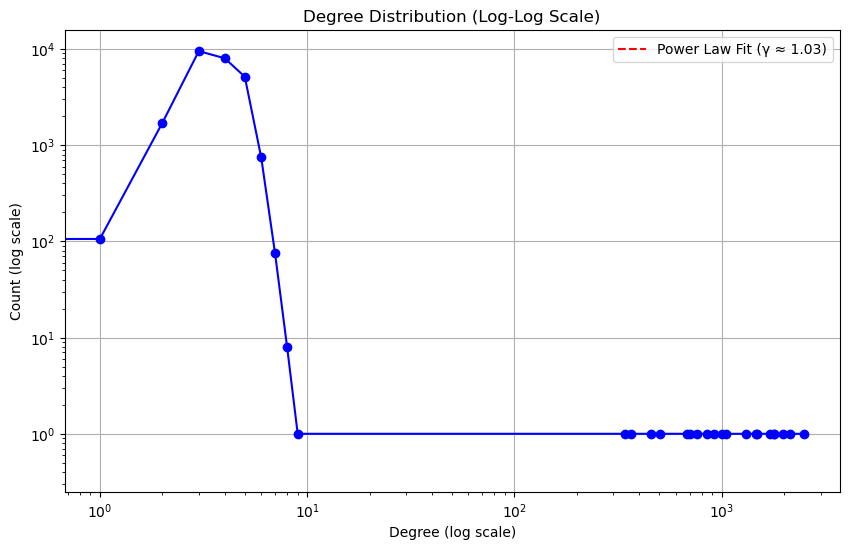

Estimated power law exponent: γ ≈ 1.03
The network may not be scale-free.


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def check_scale_free_distribution(edge_index, num_nodes):
    # Create a NetworkX graph from the edge_index
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    edge_list = edge_index.t().tolist()
    G.add_edges_from(edge_list)

    # Calculate degree for each node
    degrees = [d for n, d in G.degree()]
    degree_counts = Counter(degrees)

    # Sort the degree counts
    sorted_degree_counts = sorted(degree_counts.items())
    x = [k for k, v in sorted_degree_counts]
    y = [v for k, v in sorted_degree_counts]

    # Plot degree distribution on log-log scale
    plt.figure(figsize=(10, 6))
    plt.loglog(x, y, 'bo-')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Count (log scale)')
    plt.title('Degree Distribution (Log-Log Scale)')
    plt.grid(True)

    # Fit a power law distribution
    x_log = np.log(x)
    y_log = np.log(y)
    coeffs = np.polyfit(x_log[1:], y_log[1:], 1)
    power_law_exponent = -coeffs[0]

    # Plot the fitted line
    x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    y_fit = np.exp(coeffs[1]) * x_fit**(-power_law_exponent)
    plt.loglog(x_fit, y_fit, 'r--', label=f'Power Law Fit (γ ≈ {power_law_exponent:.2f})')

    plt.legend()
    plt.show()

    print(f"Estimated power law exponent: γ ≈ {power_law_exponent:.2f}")
    
    if 2 < power_law_exponent < 3:
        print("The network shows characteristics of a scale-free network.")
    else:
        print("The network may not be scale-free.")

    return power_law_exponent

# Usage example:
# Assuming you have a PyTorch Geometric Data object called 'data'
exponent = check_scale_free_distribution(data.edge_index, data.num_nodes)

In [11]:
data.edge_index.shape

torch.Size([2, 117916])

: 

In [12]:
gpus = hf.get_available_gpus()
best_gpu = hf.select_best_gpu(gpus)
hf.set_cuda_visible_device(best_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = hf.setup_wandb(params['project_name'], {
    "epochs": params['num_epochs'],
    "batch_size": params['batch_size'],
    "lr": params['lr'],
    "gradient_accumulation_steps": params['gradient_accumulation_steps'],
    "early_stopping_patience": params['early_stopping_patience'],
    "point_net_conv_local_mlp": params['point_net_conv_layer_structure_local_mlp'],
    "point_net_conv_global_mlp": params['point_net_conv_layer_structure_global_mlp'],
    "gat_conv_layer_structure": params['gat_conv_layer_structure'],
    "graph_mlp_layer_structure": params['graph_mlp_layer_structure'],
    "in_channels": params['in_channels'],
    "out_channels": params['out_channels'],
    "dropout": params['dropout'],
    "use_dropout": params['use_dropout']
})

model = garch.MyGnn(in_channels=config.in_channels, out_channels=config.out_channels, point_net_conv_layer_structure_local_mlp=config.point_net_conv_local_mlp,
                            point_net_conv_layer_structure_global_mlp=config.point_net_conv_global_mlp,
                            gat_conv_layer_structure=config.gat_conv_layer_structure,
                            graph_mlp_layer_structure=config.graph_mlp_layer_structure,
                            dropout=config.dropout, use_dropout=config.use_dropout)

model.to(device)

loss_fct = torch.nn.MSELoss()

baseline_loss_mean_target = gio.compute_baseline_of_mean_target(dataset=train_dl, loss_fct=loss_fct)
baseline_loss = gio.compute_baseline_of_no_policies(dataset=train_dl, loss_fct=loss_fct)
print("baseline loss mean " + str(baseline_loss_mean_target))
print("baseline loss no  " +str(baseline_loss) )

early_stopping = gio.EarlyStopping(patience=params['early_stopping_patience'], verbose=True)
best_val_loss, best_epoch = garch.train(model=model, 
            config=config, 
            loss_fct=loss_fct,
            optimizer=torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=1e-4),
            train_dl=train_dl,  
            valid_dl=valid_dl,
            device=device, 
            early_stopping=early_stopping,
            accumulation_steps=config.gradient_accumulation_steps,
            model_save_path=model_save_path,
            use_gradient_clipping=True,
            lr_scheduler_warmup_steps=20000,
            lr_scheduler_cosine_decay_rate=0.2)
print(f'Best model saved to {model_save_path} with validation loss: {best_val_loss} at epoch {best_epoch}')  

Using GPU 0 with CUDA_VISIBLE_DEVICES=0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: enatterer (tum-traffic-engineering). Use `wandb login --relogin` to force relogin


Model initialized
baseline loss mean 53.85679626464844
baseline loss no  54.41696548461914


Epoch 1/1000:   0%|          | 0/60 [00:00<?, ?it/s]/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([48, 2])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/1000: 100%|██████████| 60/60 [00:13<00:00,  4.37it/s]
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 2])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please 

epoch: 0, validation loss: 58.57643221567074, lr: 2.95e-06, r^2: -0.022925972938537598
Best model saved to ../../data/test/my_test/trained_model/model.pth with validation loss: 58.57643221567074
Checkpoint saved to ../../data/test/my_test/trained_model/checkpoints/checkpoint_epoch_0.pt


Epoch 2/1000:   2%|▏         | 1/60 [00:07<07:15,  7.39s/it]